<a href="https://colab.research.google.com/github/NichBry25/BitcoinPricePrediction/blob/main/BTCForecasting_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ensures results are replicable

import os
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models
import random

In [3]:
# Ensures results are replicable

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [4]:
df = pd.read_csv('btc_forecasting_dataset3.csv')

In [5]:
df

,Date,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,xau_logret_lag3,xau_logret_lag7,vix_logret_lag1,vix_logret_lag3,vix_logret_lag7,dxy_logret_lag1,dxy_logret_lag3,dxy_logret_lag7,btc_ma50,btc_ma200
0,2015-07-20,277.7,273.2,278.9,271.8,46600.0,2128.30,1096.95,12.25,98.03,...,-0.009696,-0.005134,0.000000,-0.013300,-0.191274,0.000000,0.001943,0.008606,252.782,246.4990
1,2015-07-21,275.1,277.7,281.0,274.2,49050.0,2119.20,1101.41,12.22,97.33,...,0.000000,-0.002135,0.024795,0.000000,-0.038875,0.001736,0.000000,-0.002274,253.822,246.2985
2,2015-07-22,276.5,275.1,277.4,273.1,41970.0,2114.20,1093.45,12.12,97.60,...,0.000000,-0.005102,-0.002452,0.000000,-0.010526,-0.007166,0.000000,0.005469,254.838,246.2455
3,2015-07-23,275.5,276.5,277.9,274.5,35660.0,2102.20,1090.80,12.64,97.11,...,-0.033306,-0.003922,-0.008217,0.024795,-0.088455,0.002770,0.001736,0.005132,255.836,246.2995
4,2015-07-24,288.4,275.5,289.8,274.3,74360.0,2079.70,1099.10,13.74,97.24,...,0.004058,-0.009696,0.042009,-0.002452,-0.013300,-0.005033,-0.007166,0.001943,257.120,246.3675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,2025-10-27,114108.0,114553.9,116307.5,113868.0,70790.0,6875.16,3981.59,15.79,98.78,...,-0.003416,0.024755,0.000000,-0.055256,-0.130922,0.000000,0.000101,0.001624,114272.866,108948.3695
3753,2025-10-28,112905.8,114110.3,116076.7,112266.9,52490.0,6890.89,3952.58,16.42,98.67,...,0.000000,-0.054579,-0.036074,0.000000,-0.019945,-0.001720,0.000000,0.003443,114289.614,109095.8330
3754,2025-10-29,110024.6,112904.7,113628.7,109506.4,66990.0,6890.59,3930.38,16.92,99.22,...,0.000000,-0.007551,0.039123,0.000000,0.040038,-0.001114,0.000000,-0.000303,114259.776,109219.4925
3755,2025-10-30,108320.1,110024.9,111585.8,106371.4,80070.0,6822.34,4024.47,16.91,99.53,...,-0.032253,0.007810,0.029996,-0.036074,-0.072455,0.005559,-0.001720,0.000404,114146.908,109342.4210


Anything beyond this section ending with "1" is representing the dataframe WITHOUT macro features. While "2" is representing WITH macro features.

In [6]:
TARGET_1 = 'btc_logret'

In [7]:
FEATURES_1 = [
    'btc_price', 'open', 'high', 'low', 'volume',
    'btc_ma50', 'btc_ma200'
]

In [8]:
TARGET_2 = 'btc_logret'

In [9]:
FEATURES_2 = [
    'btc_price','open','high','low','volume',
    'spx_price','xau_price', 'vix_price', 'dxy_price',
    'spx_logret','xau_logret', 'vix_logret', 'dxy_logret',
    'spx_logret_lag1','spx_logret_lag3','spx_logret_lag7',
    'xau_logret_lag1','xau_logret_lag3','xau_logret_lag7',
    'vix_logret_lag1','vix_logret_lag3','vix_logret_lag7',
    'dxy_logret_lag1','dxy_logret_lag3','dxy_logret_lag7',
    'btc_ma50','btc_ma200'
]

# Train - Val - Test Split

In [10]:
total_len = len(df)

In [11]:
train_end = int(total_len * 0.7)
val_end = int(total_len * 0.85)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

In [12]:
train_df.shape

(2629, 29)

In [13]:
val_df.shape

(564, 29)

In [14]:
test_df.shape

(564, 29)

# Scaling

In [15]:
scaler_1 = MinMaxScaler()

In [16]:
scaler_1.fit(train_df[FEATURES_1])

MinMaxScaler()

In [17]:
train_scaled_1 = scaler_1.transform(train_df[FEATURES_1])
val_scaled_1 = scaler_1.transform(val_df[FEATURES_1])
test_scaled_1 = scaler_1.transform(test_df[FEATURES_1])

In [18]:
scaler_2 = MinMaxScaler()

In [19]:
scaler_2.fit(train_df[FEATURES_2])

MinMaxScaler()

In [20]:
train_scaled_2 = scaler_2.transform(train_df[FEATURES_2])
val_scaled_2 = scaler_2.transform(val_df[FEATURES_2])
test_scaled_2 = scaler_2.transform(test_df[FEATURES_2])

# GRU Sequence Data

In [21]:
def make_sequence_data(values, target, lookback):
  X, y = [], []

  for i in range(lookback, len(values)):
    X.append(values[i-lookback:i])
    y.append(target[i])

  return np.array(X), np.array(y)

In [22]:
LOOKBACK = 30

In [23]:
X_train_1, y_train_1 = make_sequence_data(train_scaled_1, train_df[TARGET_1].values, LOOKBACK)
X_val_1, y_val_1 = make_sequence_data(val_scaled_1, val_df[TARGET_1].values, LOOKBACK)
X_test_1, y_test_1 = make_sequence_data(test_scaled_1, test_df[TARGET_1].values, LOOKBACK)

X_train_2, y_train_2 = make_sequence_data(train_scaled_2, train_df[TARGET_2].values, LOOKBACK)
X_val_2, y_val_2 = make_sequence_data(val_scaled_2, val_df[TARGET_2].values, LOOKBACK)
X_test_2, y_test_2 = make_sequence_data(test_scaled_2, test_df[TARGET_2].values, LOOKBACK)

# Modelling

In [24]:
def build_gru(input_shape):
  model = models.Sequential([
      layers.GRU(50, return_sequences=True, input_shape=input_shape, dropout=0.1, recurrent_dropout=0.1),
      layers.GRU(10, dropout=0.1, recurrent_dropout=0.1),
      layers.Dense(1)
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss='mse'
  )
  return model

In [25]:
model_1 = build_gru(X_train_1.shape[1:])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
X_train_1.shape[1:]

(30, 7)

In [27]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 50)         │         8,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 10)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,721 (41.88 KB)

 Trainable params: 10,721 (41.88 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model_2 = build_gru(X_train_2.shape[1:])

In [28]:
X_train_2.shape[1:]

(30, 27)

In [30]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 30, 50)         │        11,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 10)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,721 (53.60 KB)

 Trainable params: 13,721 (53.60 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [31]:
history_without_macro = model_1.fit(
    X_train_1, y_train_1,
    epochs=50,
    batch_size=100,
    validation_data=(X_val_1, y_val_1),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ],
    verbose=1
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - loss: 0.0060 - val_loss: 9.8702e-04
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0031 - val_loss: 7.0899e-04
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0023 - val_loss: 7.0709e-04
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0023 - val_loss: 8.4542e-04
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0021 - val_loss: 6.8451e-04
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0019 - val_loss: 7.6241e-04
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0018 - val_loss: 6.7302e-04
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0018 - val_loss: 6.8066e-04
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0018 - val_loss: 6.7434e-04
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0018 - val_loss: 6.7182e-04
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0017 - val_loss: 6.7818e-04
Epoch 12/50
26/26 ━

In [32]:
history_with_macro = model_2.fit(
    X_train_2, y_train_2,
    epochs=50,
    batch_size=100,
    validation_data=(X_val_2, y_val_2),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ],
    verbose=1
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 0.0416 - val_loss: 0.0027
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0123 - val_loss: 0.0011
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0081 - val_loss: 7.0928e-04
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0058 - val_loss: 0.0010
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0049 - val_loss: 9.4617e-04
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0042 - val_loss: 6.9669e-04
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0036 - val_loss: 8.6689e-04
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0033 - val_loss: 8.8858e-04
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0030 - val_loss: 7.4868e-04
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0028 - val_loss: 7.0851e-04
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0027 - val_loss: 7.0533e-04


In [33]:
y_pred_1 = model_1.predict(X_test_1).ravel()

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


In [34]:
y_pred_2 = model_2.predict(X_test_2).ravel()

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step


# Metrics

In [35]:
def calculate_performance_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    da = np.mean((y_test * y_pred) > 0)

    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "DA": da}

In [36]:
without_macro_metrics = calculate_performance_metrics(y_test_1, y_pred_1)
with_macro_metrics    = calculate_performance_metrics(y_test_2, y_pred_2)

In [37]:
without_macro_metrics

{'MSE': 0.0005689818140462472,
 'RMSE': np.float64(0.02385333968328643),
 'MAE': 0.01731750958011496,
 'DA': np.float64(0.5056179775280899)}

In [38]:
with_macro_metrics

{'MSE': 0.0009056887339102692,
 'RMSE': np.float64(0.030094662880821063),
 'MAE': 0.02364519208124644,
 'DA': np.float64(0.4943820224719101)}

# Plotting

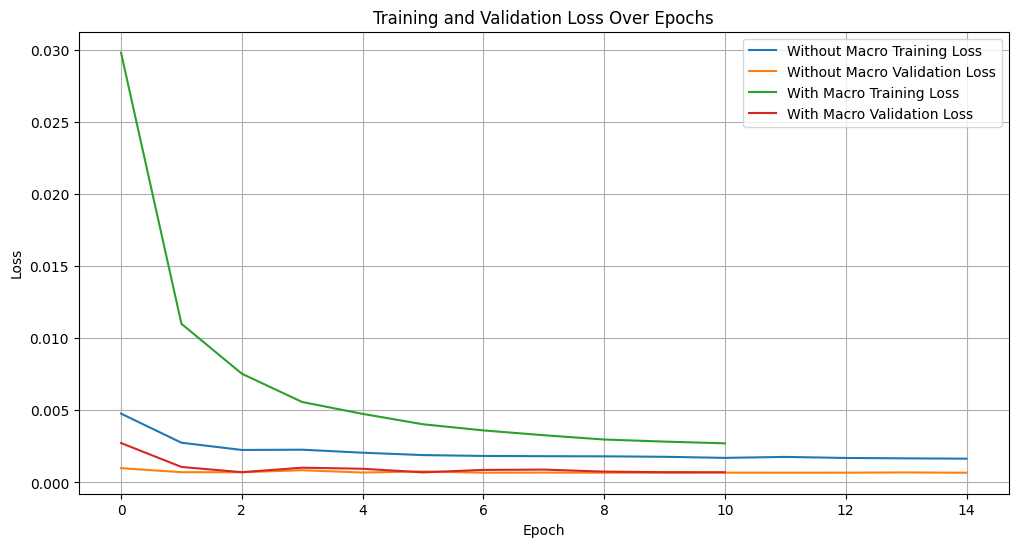

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(history_without_macro.history['loss'], label='Without Macro Training Loss')
plt.plot(history_without_macro.history['val_loss'], label='Without Macro Validation Loss')
plt.plot(history_with_macro.history['loss'], label='With Macro Training Loss')
plt.plot(history_with_macro.history['val_loss'], label='With Macro Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

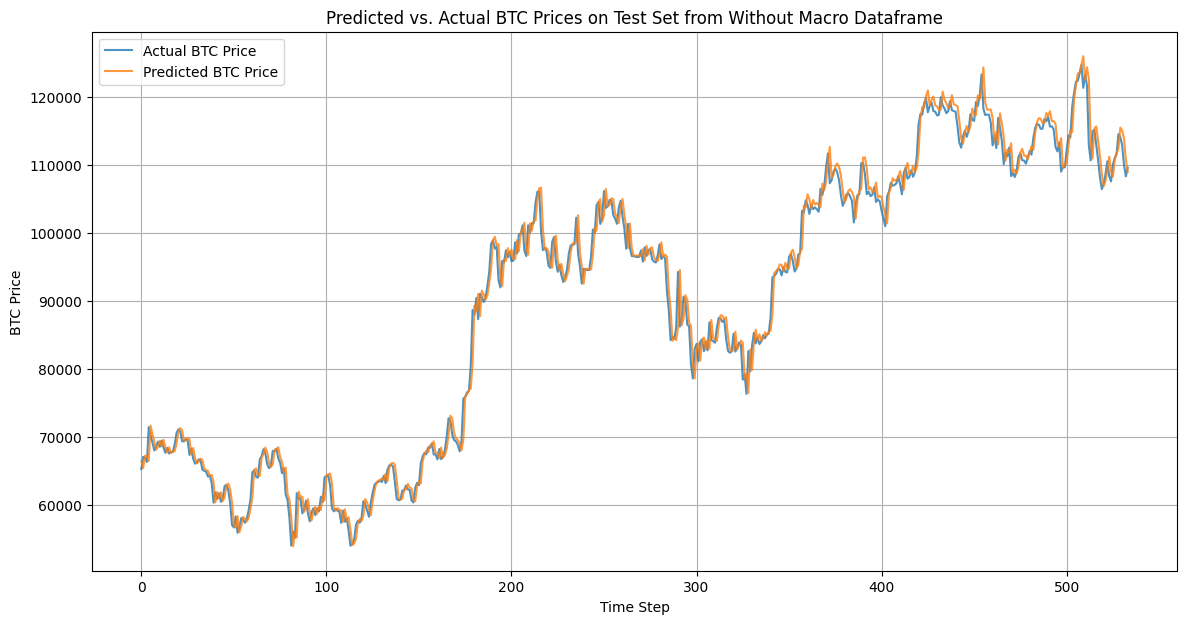

In [40]:
actual_btc_prices = test_df['btc_price'].iloc[LOOKBACK:].values
previous_btc_prices = test_df['btc_price'].iloc[LOOKBACK-1:-1].values
predicted_btc_prices = previous_btc_prices * np.exp(y_pred_1)

plt.figure(figsize=(14, 7))
plt.plot(actual_btc_prices, label='Actual BTC Price', alpha=0.8)
plt.plot(predicted_btc_prices, label='Predicted BTC Price', alpha=0.8)
plt.title('Predicted vs. Actual BTC Prices on Test Set from Without Macro Dataframe')
plt.xlabel('Time Step')
plt.ylabel('BTC Price')
plt.legend()
plt.grid(True)
plt.show()

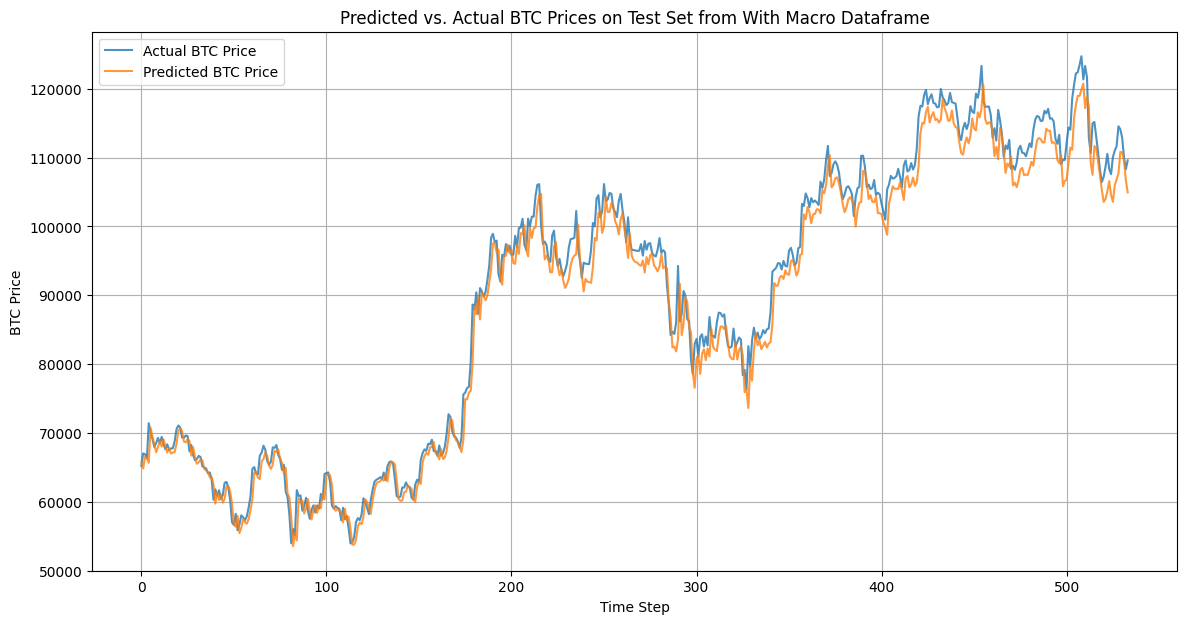

In [41]:
actual_btc_prices = test_df['btc_price'].iloc[LOOKBACK:].values
previous_btc_prices = test_df['btc_price'].iloc[LOOKBACK-1:-1].values
predicted_btc_prices = previous_btc_prices * np.exp(y_pred_2)

plt.figure(figsize=(14, 7))
plt.plot(actual_btc_prices, label='Actual BTC Price', alpha=0.8)
plt.plot(predicted_btc_prices, label='Predicted BTC Price', alpha=0.8)
plt.title('Predicted vs. Actual BTC Prices on Test Set from With Macro Dataframe')
plt.xlabel('Time Step')
plt.ylabel('BTC Price')
plt.legend()
plt.grid(True)
plt.show()